In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf

np.random.seed(3)
tf.random.set_seed(3)

### Dataset setting

In [2]:
cg = pd.read_csv('Health_checkup_data.csv')

cg_df = pd.DataFrame(cg)
cg_df = cg_df.sort_values(by=['person_id','test_age'])

In [3]:
Counter(cg_df['cancer']) # label with duplicates

Counter({0: 36377, 1: 1761})

In [4]:
persons=list(set(cg_df['person_id'].tolist()))
persons.sort()

test_p = persons[int(len(persons)*0.7):] 

In [5]:
cg_y = cg_df.loc[:,['person_id','cancer']]
cg_y = cg_y.drop_duplicates(['person_id'])

In [6]:
Counter(cg_y['cancer']) # Label without duplicates

Counter({0: 18846, 1: 610})

In [7]:
cg_df

,person_id,gender,age,test_age,EGD,bmi,alcohol_habit,smoking status,smoking_duration,amount of smoking,income,family_cancer,current_status,exercise,cancer,date
7040,10006595,0,51.0,44.0,NaN,22.02,3.0,3.0,4,2,9.0,1,0,1.0,0,2013
34558,10101102,0,84.0,67.0,NaN,26.81,2.0,3.0,5,2,8.0,1,0,1.0,0,2003
26262,10101102,0,84.0,69.0,NaN,25.54,2.0,3.0,4,1,8.0,1,0,0.0,0,2005
17171,10113905,0,86.0,69.0,NaN,23.67,3.0,3.0,5,1,9.0,1,0,0.0,0,2003
22702,10113905,0,86.0,73.0,NaN,23.03,2.0,3.0,5,2,7.0,1,0,0.0,0,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,53369201,0,74.0,56.0,NaN,NaN,1.0,3.0,4,1,7.0,1,0,0.0,1,2002
21162,53369201,0,74.0,58.0,NaN,NaN,1.0,3.0,5,1,8.0,1,0,0.0,1,2004
21163,53369201,0,74.0,58.0,NaN,NaN,1.0,3.0,5,1,8.0,1,0,0.0,1,2004
4580,53369201,0,74.0,60.0,NaN,NaN,1.0,3.0,5,1,8.0,1,0,0.0,1,2006


### Pre-progressing Pipeline

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [9]:
imputer=SimpleImputer(strategy="mean")
num_pipeline=Pipeline([
    ("select_numeric",DataFrameSelector(['bmi','age','test_age'])),
    ("scaler", StandardScaler()),
    ("imputer", imputer)
])

imputer1=SimpleImputer(fill_value=0)
num_pipeline1=Pipeline([
    ("select_numeric",DataFrameSelector(['EGD'])),
    ("scaler", StandardScaler()),
    ("imputer", imputer1)
])

In [10]:
imputer=SimpleImputer(strategy="most_frequent")
cat_pipeline = Pipeline([
    ("select_cat",DataFrameSelector(['gender','income','family_cancer','current_status'])),
    ("imputer", imputer),
    ])

imputer1=SimpleImputer(fill_value=0)
cat_pipeline1 = Pipeline([
    ("select_cat",DataFrameSelector(['smoking status','smoking_duration','amount of smoking','alcohol_habit','exercise'])),
    ("imputer", imputer1),
    ])

In [11]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("num_pipeline1", num_pipeline1),
    ("cat_pipeline", cat_pipeline),
    ("cat_pipeline1", cat_pipeline1)])

In [12]:
X=preprocess_pipeline.fit_transform(cg_df)

### 3D matrix generation & Padding

In [13]:
person_id = cg_df['person_id']
ids = person_id.iloc[0]
new_mat = []
person=[]

for i in range(len(cg_df)):  
    if ids == person_id.iloc[i]:
        person.append(X[i])
        ids = person_id.iloc[i]
    else:
        new_mat.append(person)
        person=[]
        person.append(X[i])
        ids = person_id.iloc[i]
new_mat.append(person)

In [14]:
y_label = cg_y['cancer'] # checking y_label
Counter(y_label)

Counter({0: 18846, 1: 610})

In [15]:
max_len=0
for a in new_mat:
    if len(a)>max_len:
        max_len = len(a)
        
print(max_len) # padding length

16


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_data = pad_sequences(new_mat, padding='post',dtype='float32',value=0, maxlen=max_len)

In [17]:
X_data = tf.convert_to_tensor(X_data, dtype=tf.float32)

### Split train data & test data

In [18]:
from tensorflow.keras.utils import to_categorical

In [19]:
y_label1 = to_categorical(y_label)

In [20]:
train_x = X_data[:int(0.7*len(X_data))]
test_x = X_data[int(0.7*len(X_data)):]

train_y = y_label[:int(0.7*len(y_label))]
train_y1 = to_categorical(train_y) 

test_y = y_label[int(0.7*len(y_label)):]
test_y1 = to_categorical(test_y)

### RNN Deep learning model loading

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics

In [22]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.utils import plot_model

In [23]:
model = load_model('DeepPrevention_model.h5')

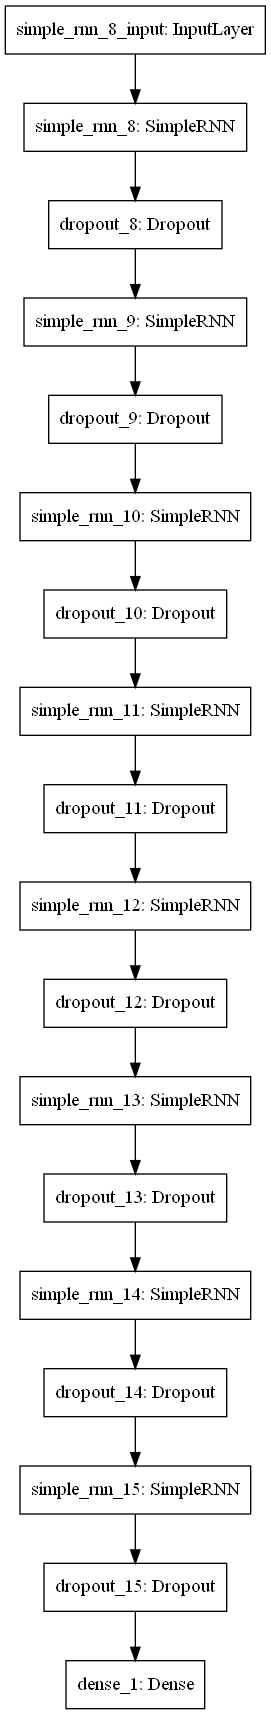

In [24]:
plot_model(model)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 16, 64)            4992      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 16, 56)            6776      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 56)            0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 16, 48)            5040      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 48)            0         
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 16, 40)           

### Deep learning Training Result

In [26]:
train_loss, train_acc  = model.evaluate(train_x, train_y1) #train data + validation data
print(f'train_loss : {train_loss}, train_acc : {train_acc}')

test_loss, test_acc = model.evaluate(test_x, test_y1) # test data
print(f'test_loss : {test_loss}, test_acc : {test_acc}')

13619/13619 [==============================] - 4s 276us/sample - loss: 0.0929 - accuracy: 0.9813
train_loss : 0.09291765131441995, train_acc : 0.9813495874404907
5837/5837 [==============================] - 1s 232us/sample - loss: 0.1079 - accuracy: 0.9764
test_loss : 0.10792401879106826, test_acc : 0.9763576984405518


In [27]:
predicted = model.predict(test_x)

rnn=[item[1] for item in predicted]

y_pred = [1 if item[1]>=0.8 else 0 for item in predicted]

In [28]:
print(Counter(test_y))
print(Counter(y_pred)) # prediction result

Counter({0: 5650, 1: 187})
Counter({0: 5719, 1: 118})


In [29]:
confusion_matrix(test_y,y_pred,labels=[1,0])

array([[  93,   94],
       [  25, 5625]], dtype=int64)

In [30]:
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5650
           1       0.79      0.50      0.61       187

    accuracy                           0.98      5837
   macro avg       0.89      0.75      0.80      5837
weighted avg       0.98      0.98      0.98      5837



0.8388036534002177


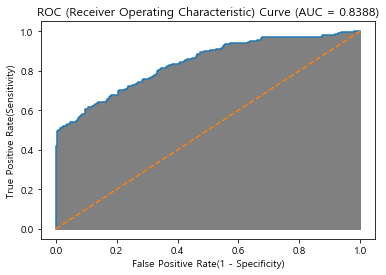

In [31]:
mpl.rc('font', family='Malgun Gothic') #한글 폰트 설정
fpr, tpr, thresholds = metrics.roc_curve(test_y, model.predict_proba(test_x)[:,1]) #곡선 그리기

plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='gray')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

score = metrics.auc(fpr, tpr) #면적 구하기
print(score) #1.0

plt.title('ROC (Receiver Operating Characteristic) Curve (AUC = {})'.format(round(score,4)))
plt.draw()
#plt.savefig('auc.png',dpi=200)

### Prediction Result + Medical check up DF

In [32]:
pre_df = pd.DataFrame(data={'person_id': test_p, 'rnn' : rnn, 'y_pred' : y_pred, 'y_real' : test_y})
pre_df = pre_df.sort_values(by=['rnn','person_id'], ascending=False)

In [33]:
pre_df = pd.merge(pre_df,cg_df,how='left',on=['person_id'])

In [34]:
pre_df

,person_id,rnn,y_pred,y_real,gender,age,test_age,EGD,bmi,alcohol_habit,smoking status,smoking_duration,amount of smoking,income,family_cancer,current_status,exercise,cancer,date
0,41708664,0.974922,1,1,0,86.0,72.0,1.0,NaN,1.0,3.0,5,1,4.0,1,0,1.0,1,2006
1,41708664,0.974922,1,1,0,86.0,72.0,1.0,NaN,1.0,3.0,5,1,4.0,1,0,1.0,1,2006
2,41708664,0.974922,1,1,0,86.0,73.0,NaN,NaN,1.0,3.0,5,1,NaN,1,0,1.0,1,2007
3,41708664,0.974922,1,1,0,86.0,73.0,NaN,NaN,1.0,3.0,5,1,NaN,1,0,1.0,1,2007
4,41187947,0.974860,1,1,0,87.0,69.0,1.0,23.73,4.0,3.0,5,2,10.0,1,0,1.0,1,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12555,49785458,0.003307,0,0,0,56.0,42.0,NaN,28.09,1.0,3.0,4,3,9.0,1,0,1.0,0,2006
12556,49785458,0.003307,0,0,0,56.0,43.0,NaN,27.76,1.0,3.0,5,3,9.0,1,0,1.0,0,2007
12557,49785458,0.003307,0,0,0,56.0,44.0,NaN,27.76,3.0,3.0,4,3,9.0,0,0,1.0,0,2008
12558,49785458,0.003307,0,0,0,56.0,47.0,NaN,28.41,1.0,3.0,4,3,9.0,1,0,1.0,0,2011


In [35]:
#pre_df.to_csv("DP_result.csv",mode='w',index=False)